In [489]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import datetime as dt
import jenkspy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import seaborn as sns

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer 
from sklearn.metrics import silhouette_score

import hdbscan

In [490]:
customers = pd.read_excel(open('./KPMG_VI_New_raw_data_update_final2.xlsx', 'rb'),
              sheet_name='CustomerDemographic') 

transactions = pd.read_excel(open('./KPMG_VI_New_raw_data_update_final2.xlsx', 'rb'),
              sheet_name='Transactions')

new_customer = pd.read_excel(open('./KPMG_VI_New_raw_data_update_final2.xlsx', 'rb'),
              sheet_name='NewCustomerList') 

addresses = pd.read_excel(open('./KPMG_VI_New_raw_data_update_final2.xlsx', 'rb'),
              sheet_name='CustomerAddress') 

## Data cleaning

In [491]:
customers.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure
0,1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,2018-02-01 00:00:00,Yes,15.0
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0


In [492]:
# delete record where DOB is 1843
customers.drop(customers.index[[33]], inplace=True)

# Fix the typos in the Job Industry Category
customers['job_industry_category'] = customers['job_industry_category'].replace({'Argiculture': 'Agriculture'})

# Drop the columns that will not be used for analysis
customers.drop(columns=['default', 'first_name', 'last_name'], axis=1, inplace=True)

# drop rows where there are missing values for Tenure and DOB
customers.dropna(subset=['DOB', 'tenure'], inplace=True)

# Impute missing data with 'Unspecified'
customers.fillna('Unspecified', inplace=True)

# remove two customers who have deceased
customers = customers[customers['deceased_indicator'] == 'N']
# drop deceased_indicator column
customers.drop('deceased_indicator', axis=1, inplace=True)

# relabel genders to make consistent
customers['gender'] = customers['gender'].replace({'Femal':'Female', 'M':'Male', 'F':'Female'})

# relabel columns to be binary
customers['owns_car'].replace({'Yes':1, 'No':0})

0       1
1       1
2       1
3       0
4       1
       ..
3994    1
3995    0
3996    1
3998    1
3999    0
Name: owns_car, Length: 3910, dtype: int64

In [493]:
customers.head()

,customer_id,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,owns_car,tenure
0,1,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,Yes,11.0
1,2,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,Yes,16.0
2,3,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,Yes,15.0
3,4,Male,33,1961-10-03,Unspecified,IT,Mass Customer,No,7.0
4,5,Female,56,1977-05-13,Senior Editor,Unspecified,Affluent Customer,Yes,8.0


In [494]:
# create age feature
customers['age'] = (dt.datetime.now() - customers['DOB']) / np.timedelta64(1, 'Y')

# create age bins
customers['age_brackets'] = ((round(customers['age'] / 10)) * 10).astype(int)

In [495]:
customers.head()

,customer_id,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,owns_car,tenure,age,age_brackets
0,1,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,Yes,11.0,67.030567,70
1,2,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,Yes,16.0,39.851364,40
2,3,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,Yes,15.0,66.756776,70
3,4,Male,33,1961-10-03,Unspecified,IT,Mass Customer,No,7.0,59.055044,60
4,5,Female,56,1977-05-13,Senior Editor,Unspecified,Affluent Customer,Yes,8.0,43.446236,40


### Customer_Addresses

In [496]:
# keep state data consistent
addresses['state'] = addresses['state'].replace({'New South Wales':'NSW', 'Victoria':'VIC'})

# drop country column as its not useful as there is only one variable
addresses.drop('country', axis=1, inplace=True)


In [497]:
addresses.isnull().sum()

customer_id           0
address               0
postcode              0
state                 0
property_valuation    0
dtype: int64

## Transactions

In [498]:
transactions.isnull().sum()

transaction_id               0
product_id                   0
customer_id                  0
transaction_date             0
online_order               360
order_status                 0
brand                      197
product_line               197
product_class              197
product_size               197
list_price                   0
standard_cost              197
product_first_sold_date    197
dtype: int64

In [499]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_date  19803 n

In [500]:
# delete records with missing values
transactions.dropna(inplace=True)

# convert product_first_sold_date to datetime dtype
transactions['product_first_sold_date'] = pd.TimedeltaIndex(transactions['product_first_sold_date'], unit='d') + dt.datetime(1900,1,1)

# create feature for recency
transactions['days_since_last_purchase'] = transactions['transaction_date'].max() - transactions['transaction_date']
transactions['days_since_last_purchase'] = transactions['days_since_last_purchase'] / np.timedelta64(1, 'D') 

In [501]:
# create profit column
transactions['profit'] = transactions['list_price'] - transactions['standard_cost']

In [502]:
transactions.describe().T

,count,mean,std,min,25%,50%,75%,max
transaction_id,19445.0,9989.257393,5779.669087,1.00,4976.00,9985.00,14997.00,20000.00
product_id,19445.0,45.797737,30.571996,0.00,18.00,45.00,72.00,100.00
customer_id,19445.0,1739.467267,1011.889153,1.00,857.00,1741.00,2615.00,5034.00
online_order,19445.0,0.500849,0.500012,0.00,0.00,1.00,1.00,1.00
list_price,19445.0,1107.337193,582.662400,12.01,575.27,1163.89,1635.30,2091.47
standard_cost,19445.0,555.585260,405.596541,7.21,215.14,507.58,795.10,1759.85
days_since_last_purchase,19445.0,181.318539,105.344154,0.00,89.00,180.00,273.00,363.00
profit,19445.0,551.751933,493.211843,4.80,133.78,445.21,830.24,1702.55


# Exploratory Data Analysis

In [503]:
# combine customer and customer_address datasets into a single DataFrame
df = customers.merge(addresses, how='left', on='customer_id')

In [504]:
df.head()

,customer_id,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,owns_car,tenure,age,age_brackets,address,postcode,state,property_valuation
0,1,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,Yes,11.0,67.030567,70,060 Morning Avenue,2016.0,NSW,10.0
1,2,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,Yes,16.0,39.851364,40,6 Meadow Vale Court,2153.0,NSW,10.0
2,3,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,Yes,15.0,66.756776,70,NaN,NaN,NaN,NaN
3,4,Male,33,1961-10-03,Unspecified,IT,Mass Customer,No,7.0,59.055044,60,0 Holy Cross Court,4211.0,QLD,9.0
4,5,Female,56,1977-05-13,Senior Editor,Unspecified,Affluent Customer,Yes,8.0,43.446236,40,17979 Del Mar Point,2448.0,NSW,4.0


Text(0.5, 1.0, 'Age Distribution by State')

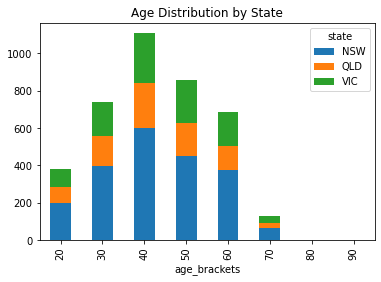

In [505]:
df.groupby(['age_brackets', 'state']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Age Distribution by State')

Text(0.5, 1.0, 'Age Distribution by Gender')

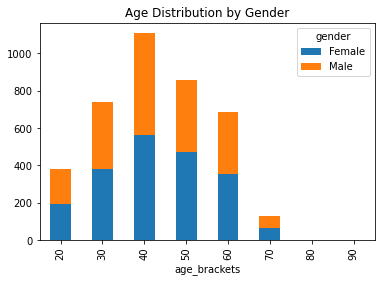

In [506]:
df.groupby(['age_brackets', 'gender']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Age Distribution by Gender')

(array([0, 1, 2]), [Text(0, 0, 'NSW'), Text(1, 0, 'QLD'), Text(2, 0, 'VIC')])

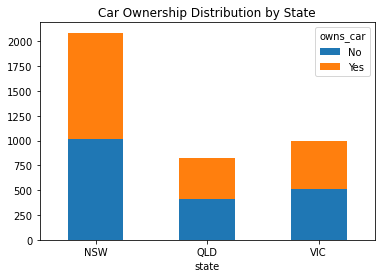

In [507]:
df.groupby(['state', 'owns_car']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Car Ownership Distribution by State')
plt.xticks(rotation=0)

Text(0.5, 1.0, 'Car Ownership Distribution by Job Industry')

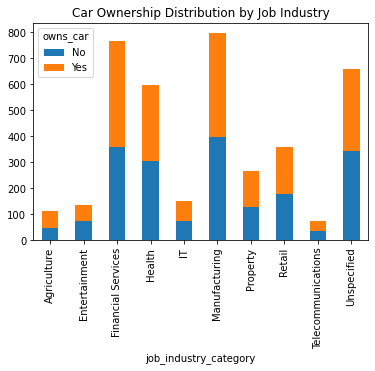

In [508]:
df.groupby(['job_industry_category', 'owns_car']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Car Ownership Distribution by Job Industry')

C:\Users\vinhe\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age'>

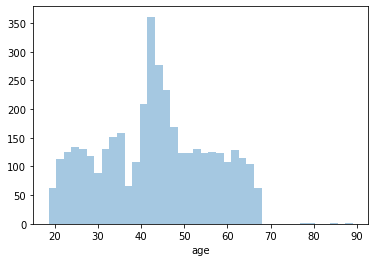

In [509]:
sns.distplot(df['age'], kde=False, bins=40)

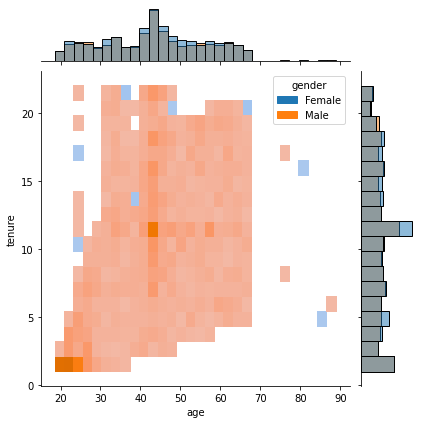

In [510]:
# two distribution plots with a scatter plot showing regression inbetween for age and tenure
sns.jointplot(x='age', y='tenure', data=df, kind='hist', hue='gender')

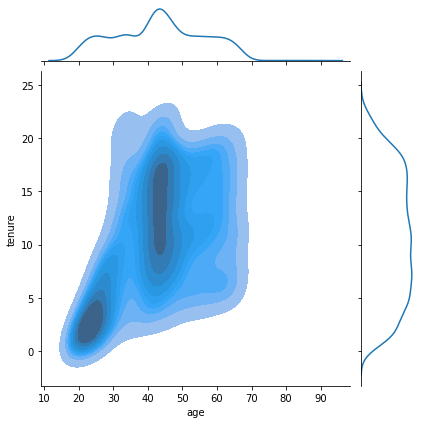

In [511]:
# two distribution plots with a two-dimensional KDE inbetween for age and tenure
sns.jointplot(x='age', y='tenure', data=df, kind='kde', shade=True)

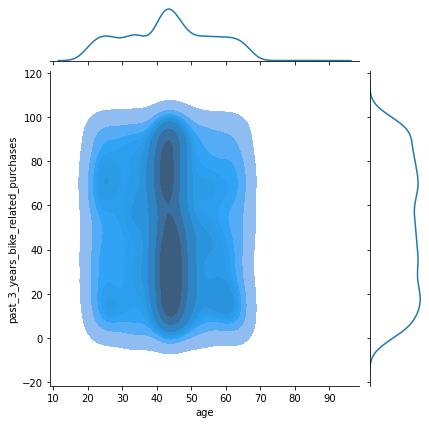

In [512]:
sns.jointplot(x='age', y='past_3_years_bike_related_purchases', data=df, kind='kde', shade=True)

<AxesSubplot:xlabel='owns_car', ylabel='age'>

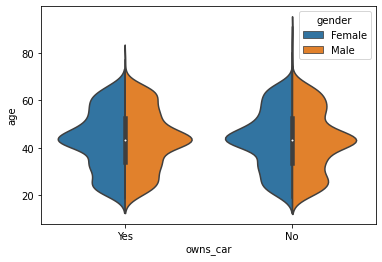

In [513]:
sns.violinplot(x='owns_car',y='age',data=df, hue='gender',split=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Health'),
  Text(1, 0, 'Financial Services'),
  Text(2, 0, 'Property'),
  Text(3, 0, 'IT'),
  Text(4, 0, 'Unspecified'),
  Text(5, 0, 'Retail'),
  Text(6, 0, 'Agriculture'),
  Text(7, 0, 'Manufacturing'),
  Text(8, 0, 'Telecommunications'),
  Text(9, 0, 'Entertainment')])

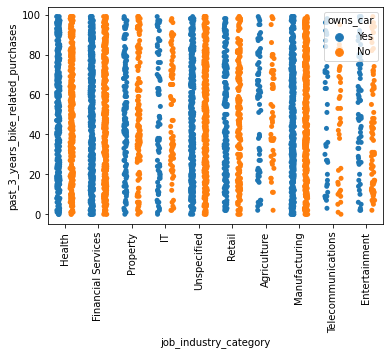

In [514]:
sns.stripplot(x='job_industry_category',y='past_3_years_bike_related_purchases', data=customers, jitter=True, hue='owns_car', dodge=True)
plt.xticks(rotation=90)

<AxesSubplot:xlabel='state', ylabel='age'>

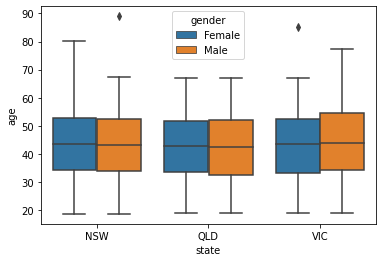

In [515]:
sns.boxplot(x='state',y='age',data=df,hue='gender')

<AxesSubplot:xlabel='wealth_segment', ylabel='age'>

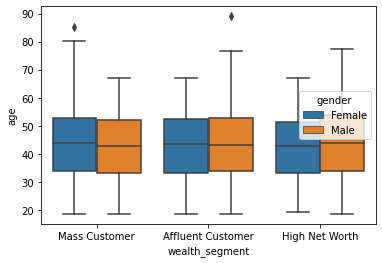

In [516]:
sns.boxplot(x='wealth_segment',y='age',data=df,hue='gender')

<AxesSubplot:xlabel='wealth_segment', ylabel='past_3_years_bike_related_purchases'>

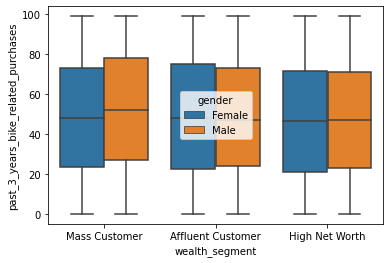

In [517]:
sns.boxplot(x='wealth_segment',y='past_3_years_bike_related_purchases',data=df,hue='gender')

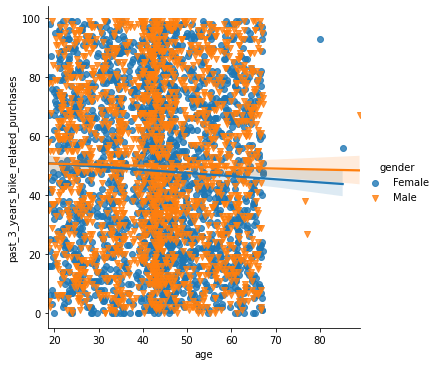

In [518]:
sns.lmplot(x='age',y='past_3_years_bike_related_purchases',data=df,hue='gender',markers=['o','v'])

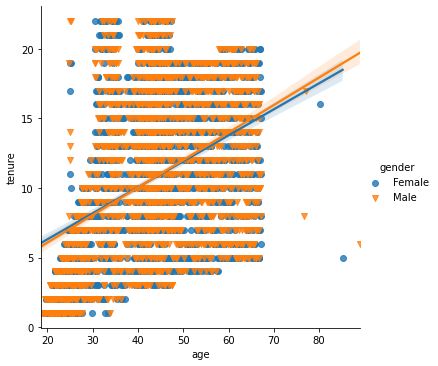

In [519]:
sns.lmplot(x='age',y='tenure',data=df,hue='gender',markers=['o','v'])

Text(0.5, 1.0, 'Age by Property Value')

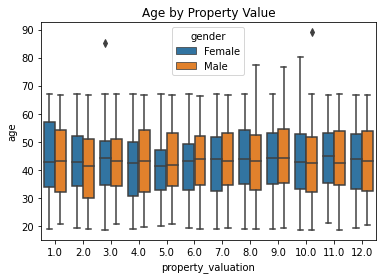

In [520]:
sns.boxplot(x='property_valuation',y='age',data=df,hue='gender')
plt.title('Age by Property Value')

Text(0.5, 1.0, 'Purchase Quantity by Property Value')

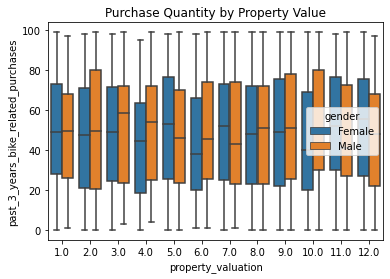

In [521]:
sns.boxplot(x='property_valuation',y='past_3_years_bike_related_purchases',data=df,hue='gender')
plt.title('Purchase Quantity by Property Value')

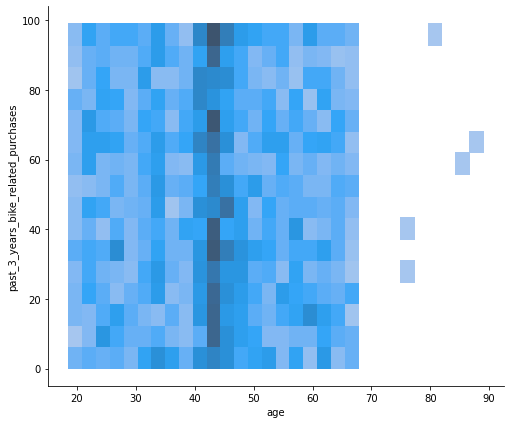

In [522]:
sns.displot(data=df, x='age', y='past_3_years_bike_related_purchases',
kind='hist', height=6, aspect=1.2)

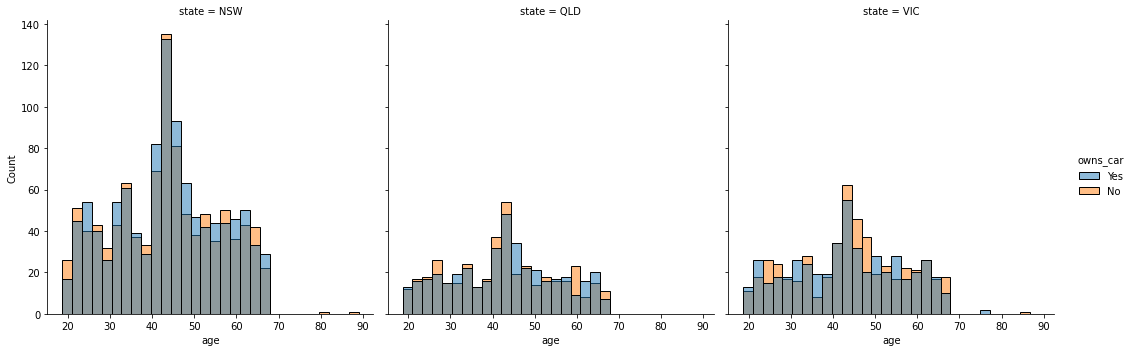

In [523]:
sns.displot(data=df, x='age', kind='hist',
col='state', hue='owns_car')

# RFM Analysis for Customer Segmentation
RFM (Recency, Frequency, Monetary Value) is a popular method for analysing customer value. It is used in database marketing and direct marketing. 

Customer transactions are represented by a table with columns for:
- custmer name
- date of purchase
- purchase value

typically, a score between 1 to 10 is assigned to each feature, where a higher score represents the preferred customer. These scores are then used to calculate a final score to rank the customers.

In [524]:
rfm = transactions.groupby('customer_id').agg({
    'days_since_last_purchase': lambda x: x.min(),
    'customer_id': lambda x: len(x),
    'profit': lambda x: x.sum()
})

rfm = rfm.rename(columns={'days_since_last_purchase': 'recency',
    'customer_id': 'frequency',
    'profit': 'monetary'
})

In [525]:
rfm.head()

,recency,frequency,monetary
customer_id,,,
1,7.0,11,3018.09
2,128.0,3,2226.26
3,102.0,7,3290.21
4,195.0,2,220.57
5,16.0,6,2394.94


In [526]:
# get percentiles and quartiles
rfm['r_percentile'] = rfm['recency'].rank(pct=True, ascending=False)
rfm['r_score'] = pd.qcut(rfm['r_percentile'], 4, labels=range(4,0,-1))

rfm['f_percentile'] = rfm['frequency'].rank(pct=True, ascending=True)
rfm['f_score'] = pd.qcut(rfm['f_percentile'], 4, labels=range(4,0,-1))

rfm['m_percentile'] = rfm['monetary'].rank(pct=True, ascending=True)
rfm['m_score'] = pd.qcut(rfm['m_percentile'], 4, labels=range(4,0,-1))

In [527]:
# now our table has recency, frequency, and monetary columns, and the respective percentile and quartile for each value
rfm.head()

,recency,frequency,monetary,r_percentile,r_score,f_percentile,f_score,m_percentile,m_score
customer_id,,,,,,,,,
1,7.0,11,3018.09,0.896764,1,0.981959,1,0.543814,2
2,128.0,3,2226.26,0.136312,4,0.134737,4,0.351947,3
3,102.0,7,3290.21,0.199026,4,0.744129,2,0.597938,2
4,195.0,2,220.57,0.041667,4,0.047251,4,0.016323,4
5,16.0,6,2394.94,0.772050,1,0.598797,2,0.393471,3


In [528]:
# we can check if the scores look right
quartiles = rfm.quantile(q = [0.25, 0.5, 0.75])
quartiles

,recency,frequency,monetary,r_percentile,f_percentile,m_percentile
0.25,18.0,4.0,1797.43,0.248711,0.268471,0.250215
0.50,45.0,5.0,2798.99,0.498425,0.430556,0.500143
0.75,88.0,7.0,4122.44,0.746277,0.744129,0.750072


In [529]:
# now to concatenate the three score columns
rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)
rfm.head()

,recency,frequency,monetary,r_percentile,r_score,f_percentile,f_score,m_percentile,m_score,rfm_score
customer_id,,,,,,,,,,
1,7.0,11,3018.09,0.896764,1,0.981959,1,0.543814,2,112
2,128.0,3,2226.26,0.136312,4,0.134737,4,0.351947,3,443
3,102.0,7,3290.21,0.199026,4,0.744129,2,0.597938,2,422
4,195.0,2,220.57,0.041667,4,0.047251,4,0.016323,4,444
5,16.0,6,2394.94,0.772050,1,0.598797,2,0.393471,3,123


### Let's explore the RFM data

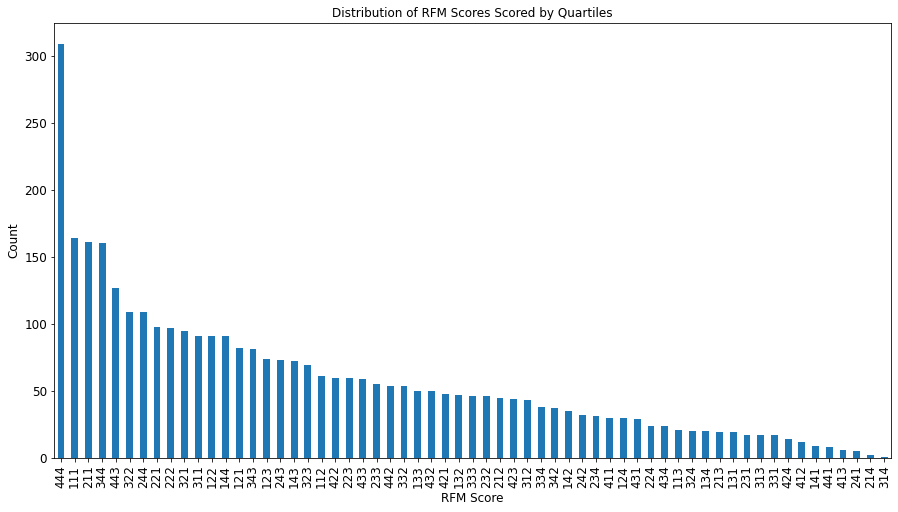

In [530]:
# let's see distribution of RFM scores
ax = rfm['rfm_score'].value_counts().plot(kind='bar', figsize=(15, 8), fontsize=12)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.title('Distribution of RFM Scores Scored by Quartiles')
plt.show()


We can see that the largest segment is made up of the least valuable customers. However, the next largest segment is made up by the most valuable customers, which seems strange. Let's investigate how the data was partitioned:

In [531]:
r_quarters = rfm['recency'].quantile(q=[0.0, 0.25,0.5,0.75, 1]).to_list()
f_quarters = rfm['frequency'].quantile(q=[0.0, 0.25,0.5,0.75, 1]).to_list()
m_quarters = rfm['monetary'].quantile(q=[0.0, 0.25,0.5,0.75, 1]).to_list()
quartile_spread = pd.DataFrame(list(zip(r_quarters, f_quarters, m_quarters)), 
                      columns=['q_recency','q_frequency', 'q_monetary'],
                     index = ['min', 'first_part','second_part','third_part', 'max'])
quartile_spread

,q_recency,q_frequency,q_monetary
min,0.0,1.0,15.08
first_part,18.0,4.0,1797.43
second_part,45.0,5.0,2798.99
third_part,88.0,7.0,4122.44
max,353.0,14.0,11668.95


Let's visualise the histogram with the partitions marked along the x-axis:

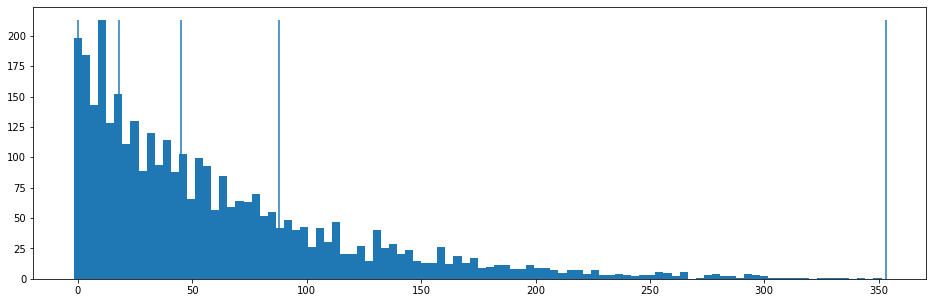

In [532]:
plt.figure(figsize=(16,5))
hist = plt.hist(rfm['recency'], bins=100, align='left')
for quarter in r_quarters:
    plt.vlines(quarter, ymin=0, ymax=max(hist[0]))

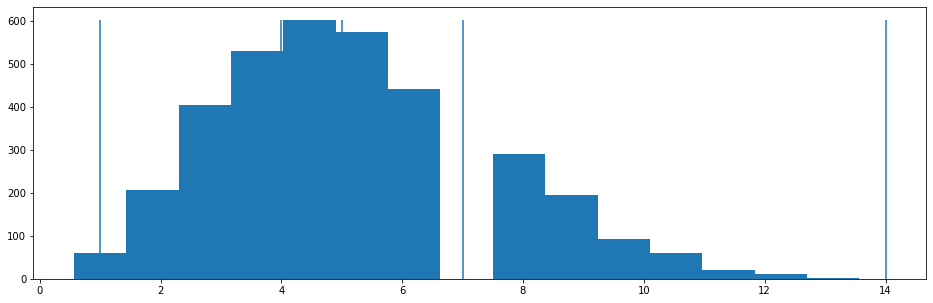

In [533]:
plt.figure(figsize=(16,5))
hist = plt.hist(rfm['frequency'], bins=15, align='left')
for quarter in f_quarters:
    plt.vlines(quarter, ymin=0, ymax=max(hist[0]))

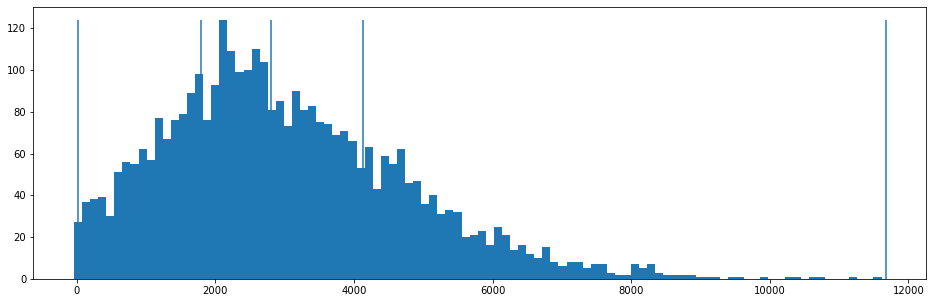

In [534]:
plt.figure(figsize=(16,5))
hist = plt.hist(rfm['monetary'], bins=100, align='left')
for quarter in m_quarters:
    plt.vlines(quarter, ymin=0, ymax=max(hist[0]))

### Jenks Natural Breaks 
The Jenks natural breaks classification method is a data clustering method designed to determine the best arrangement of values into different classes. The method seeks to reduce the variance within classes and maximise the variance between classes. let's explore how using Jenks to partition the data differs from using quartikes:

In [535]:
# crediting Ian Felton for notebook on Jenks Natural Breaks
# https://towardsdatascience.com/rfm-segmentation-using-quartiles-and-jenks-natural-breaks-924f4d8baee1

r_breaks = jenkspy.jenks_breaks(rfm['recency'], nb_class=4)
f_breaks = jenkspy.jenks_breaks(rfm['frequency'], nb_class=4)
m_breaks = jenkspy.jenks_breaks(rfm['monetary'], nb_class=4)
jenks_spread = pd.DataFrame(list(zip(r_breaks, f_breaks, m_breaks)),
                           columns=['j_recency', 'j_frequency', 'j_monetary'],
                           index=['min', 'first_part','second_part','third_part', 'max'])
jenks_spread

,j_recency,j_frequency,j_monetary
min,0.0,1.0,15.08
first_part,44.0,3.0,1951.07
second_part,102.0,5.0,3592.50
third_part,184.0,8.0,5625.17
max,353.0,14.0,11668.95


Combine the tables to compare the values from using quartiles and Jenks breaks:

In [536]:
comparison_df = pd.concat([quartile_spread, jenks_spread], axis=1)
comparison_df

,q_recency,q_frequency,q_monetary,j_recency,j_frequency,j_monetary
min,0.0,1.0,15.08,0.0,1.0,15.08
first_part,18.0,4.0,1797.43,44.0,3.0,1951.07
second_part,45.0,5.0,2798.99,102.0,5.0,3592.50
third_part,88.0,7.0,4122.44,184.0,8.0,5625.17
max,353.0,14.0,11668.95,353.0,14.0,11668.95


In [537]:
breaks_list = [r_breaks, f_breaks, m_breaks]

rfm['r_j_score'] = pd.cut(rfm['recency'], bins=r_breaks, labels=[1, 2, 3, 4], include_lowest=True)
rfm['f_j_score'] = pd.cut(rfm['frequency'], bins=f_breaks, labels=[4, 3, 2, 1], include_lowest=True)
rfm['m_j_score'] = pd.cut(rfm['monetary'], bins=m_breaks, labels=[4, 3, 2, 1], include_lowest=True)

rfm.drop(['r_percentile', 'f_percentile', 'm_percentile'], axis=1, inplace=True)
rfm['rfm_j_score'] = rfm['r_j_score'].astype(str) + rfm['f_j_score'].astype(str) + rfm['m_j_score'].astype(str)

In [538]:
rfm.head()

,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,r_j_score,f_j_score,m_j_score,rfm_j_score
customer_id,,,,,,,,,,,
1,7.0,11,3018.09,1,1,2,112,1,1,3,113
2,128.0,3,2226.26,4,4,3,443,3,4,3,343
3,102.0,7,3290.21,4,2,2,422,2,2,3,223
4,195.0,2,220.57,4,4,4,444,4,4,4,444
5,16.0,6,2394.94,1,2,3,123,1,2,3,123


Let's visualise the difference:

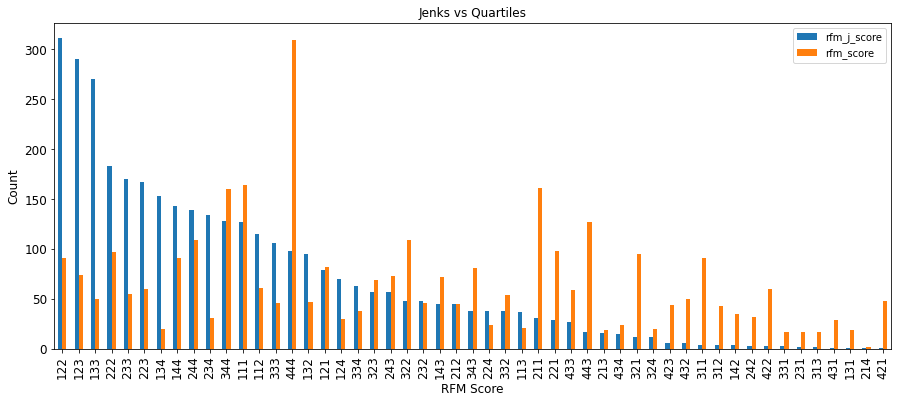

In [539]:
comparison_df2 = rfm['rfm_j_score'].value_counts().to_frame().join(rfm['rfm_score'].value_counts())
ax = comparison_df2.plot(kind='bar', 
                         title="Jenks vs Quartiles", 
                         figsize=(15, 6),
                         legend=True,
                         fontsize=12)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

The plot shows that the two methods produce very different results. Segmentation using Jenks Natural Breaks show the greatest number of clusters for recent but infrequent customers with low total amount spent. 

Who are the top 5 best customers?

In [540]:
rfm[rfm['rfm_j_score'] == '111'].sort_values(by='monetary', ascending=False).head()

,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,r_j_score,f_j_score,m_j_score,rfm_j_score
customer_id,,,,,,,,,,,
941,33.0,10,11668.95,2,1,1,211,1,1,1,111
1558,8.0,9,10640.30,1,1,1,111,1,1,1,111
3326,29.0,13,10422.04,2,1,1,211,1,1,1,111
322,1.0,11,10336.77,1,1,1,111,1,1,1,111
2770,30.0,9,10028.80,2,1,1,211,1,1,1,111


|Segment|RFM|Description|Marketing| 
|-----|-------|------|--------| 
|Best customers|111|	Customers who bought most recently, most often and spend the most.|No price incentives, New products and loyalty programs|
|Loyal customers|X1X|Customers who bought most recently|Use R and M to further segment|
|Big Spenders|XX1|Customers who spend the most | Market your most expensive products|
|Recent Customers | [1-2]XX| Customers who have recently purchased | Soft marketing |
|Almost Lost|311|Haven't purchased for some time, but purchased frequently and spend the most.|Aggressive price incentives|
|Lost Customers|411|Haven't purchased for some time, but purchased frequently and spend the most.|Aggressive price incentives|
|Lost Cheap Customers|444|Last purchase long ago, purchased few and spend little.|Don't spend too much trying to re-acquire|

I'd like to credit Joao Correia for the marketing insights: https://joaocorreia.io/blog/rfm-analysis-increase-sales-by-segmenting-your-customers.html

#### RFM segmentation insights are as follows:

In [541]:
rfm_segmentation_map = {
    r'111': '1 best customers',
    r'[1-2][1-2][1-4]': '2 loyal customers',
    r'[1-4][1-4][1-2]': '3 big spenders',
    r'[3-4][1-3][1-4]': '4 almost lost',
    r'[1-2][3-4][3-4]': '5 recent customers',
    r'[4][1][1]': '6 lost customers',
    r'[3-4][2-4][3-4]': '7 lost cheap customers',
}

In [542]:
rfm['rfm_segment'] = rfm['rfm_score'].astype(str)
rfm['rfm_segment'] = rfm['rfm_segment'].replace(rfm_segmentation_map, regex=True)

In [543]:
rfm['rfm_j_segment'] = rfm['rfm_j_score'].astype(str)
rfm['rfm_j_segment'] = rfm['rfm_j_segment'].replace(rfm_segmentation_map, regex=True)

In [544]:
rfm.rfm_segment.value_counts()

3 big spenders            947
2 loyal customers         865
7 lost cheap customers    677
5 recent customers        501
4 almost lost             338
1 best customers          164
Name: rfm_segment, dtype: int64

# Customer segmentation with K-means clustering
K-means clustering is one of the simplest and popular unsupervised machine learning algorithms. The objective of K-means is to group similar data points together and discover underlying patterns. To achieve this objective, K-means looks for a fixed number (k) of clusters in a dataset. A cluster refers to a collection of data points aggregated together because of certain similarities.

In [545]:
rfm.head()

,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,r_j_score,f_j_score,m_j_score,rfm_j_score,rfm_segment,rfm_j_segment
customer_id,,,,,,,,,,,,,
1,7.0,11,3018.09,1,1,2,112,1,1,3,113,2 loyal customers,2 loyal customers
2,128.0,3,2226.26,4,4,3,443,3,4,3,343,7 lost cheap customers,7 lost cheap customers
3,102.0,7,3290.21,4,2,2,422,2,2,3,223,3 big spenders,2 loyal customers
4,195.0,2,220.57,4,4,4,444,4,4,4,444,7 lost cheap customers,7 lost cheap customers
5,16.0,6,2394.94,1,2,3,123,1,2,3,123,2 loyal customers,2 loyal customers


In [546]:
kmeans = KMeans(n_clusters=5, max_iter=100)
kmeans.fit(rfm[['recency', 'frequency', 'monetary']])

KMeans(max_iter=100, n_clusters=5)

We start by finding the optimal number of clusters for the k-means algorithm. We will use the elbow method. First, we need to perform k-means clustering for a range of values for k. Then for each value of k, the average score for all clusters is calculated. As the scoring metric, we used inertia, which is the sum of the distances from each data point to its assigned cluster centroid. Next, we plot inertia versus k and looked for the ‘elbow’ point (the point at which decrease starts to slow down).

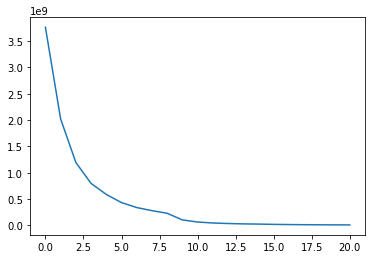

In [547]:
# elbow-curve / sum of squared differences (SSD)

ssd = []
range_n_clusters = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,50,60,70,80,90,100]

for n in range_n_clusters:
    kmeans = KMeans(n_clusters=n,
                    max_iter=200)
    kmeans.fit(rfm[['recency', 'frequency', 'monetary']])
    
    ssd.append(kmeans.inertia_)
    
# plot SSDs for each n_clusters
plt.plot(ssd)

It looks like decrease starts to slow down at 9 clusters. I decided to use 9 clusters to perform k-means clustering.  Let’s now create clusters and see their characteristics. 

In [548]:
# choose k = 9
kmeans = KMeans(n_clusters=9, max_iter=100)
kmeans.fit(rfm[['recency', 'frequency', 'monetary']])

KMeans(max_iter=100, n_clusters=9)

In [549]:
# assign the labels to the dataframe
rfm['kmeans_cluster'] = pd.Series(kmeans.labels_, index=rfm.index)
rfm.head()

,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,r_j_score,f_j_score,m_j_score,rfm_j_score,rfm_segment,rfm_j_segment,kmeans_cluster
customer_id,,,,,,,,,,,,,,
1,7.0,11,3018.09,1,1,2,112,1,1,3,113,2 loyal customers,2 loyal customers,4
2,128.0,3,2226.26,4,4,3,443,3,4,3,343,7 lost cheap customers,7 lost cheap customers,1
3,102.0,7,3290.21,4,2,2,422,2,2,3,223,3 big spenders,2 loyal customers,4
4,195.0,2,220.57,4,4,4,444,4,4,4,444,7 lost cheap customers,7 lost cheap customers,3
5,16.0,6,2394.94,1,2,3,123,1,2,3,123,2 loyal customers,2 loyal customers,1


In [550]:
myDict = {}
for i in range(0, len(rfm['kmeans_cluster'].unique())):
    clust = rfm[rfm['kmeans_cluster'] == i]
    myDict['kmeans_cluster ' + str(i)] = [int(round(clust['recency'].mean(),0)),
                            int(round(clust['frequency'].mean(),0)),
                            int(round(clust['monetary'].mean(),0)),
                            int(round(clust['recency'].median(),0)),
                            int(round(clust['frequency'].median(),0)),
                            int(round(clust['monetary'].median(),0))]
    
comparison_df4 = pd.DataFrame.from_dict(myDict, orient='index',
                            columns=['mean_recency','mean_frequency', 'mean_monetary',
                                    'median_recency','median_frequency', 'median_monetary'])
comparison_df4

,mean_recency,mean_frequency,mean_monetary,median_recency,median_frequency,median_monetary
kmeans_cluster 0,53,6,3708,41,6,3688
kmeans_cluster 1,64,5,2192,47,5,2194
kmeans_cluster 2,36,9,6804,26,9,6753
kmeans_cluster 3,104,3,592,84,3,649
kmeans_cluster 4,59,6,2895,44,5,2881
kmeans_cluster 5,33,10,8788,25,10,8366
kmeans_cluster 6,45,8,5579,35,8,5521
kmeans_cluster 7,45,7,4615,35,7,4611
kmeans_cluster 8,77,4,1456,58,4,1471


In [552]:
kmeans_segmentation_map = {
    5: 1,
    2: 2,
    6: 3, 
    7: 4,
    0: 5,
    4: 6,  
    1: 7,
    8: 8,    
    3: 9,    
}

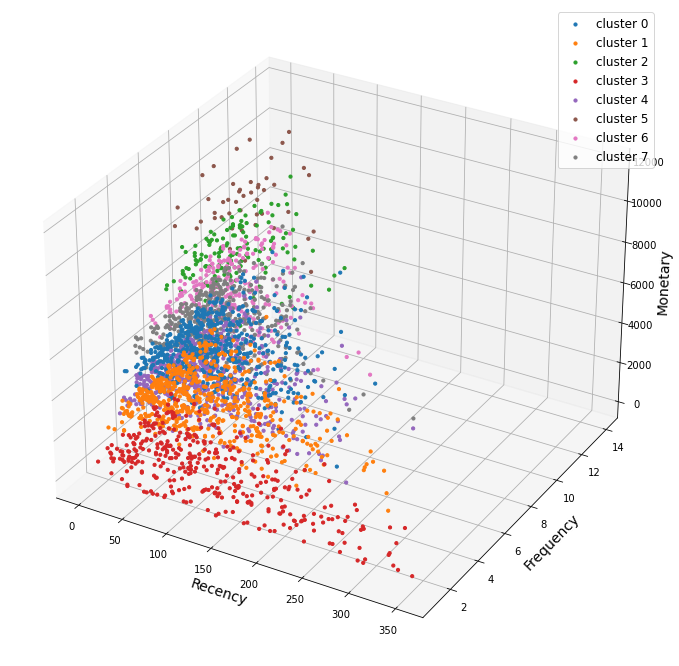

In [553]:
palette = sns.color_palette()

fig = plt.figure(figsize=(18,12))
dx = fig.add_subplot(111, projection='3d')
colors = palette
#colors = ['green', 'blue', 'red', 'yellow', 'pink', 'purple', 'black', 'navy']
#colors = [ k for k in mcolors.CSS4_COLORS ]

for i in range(0,len(rfm['kmeans_cluster'].unique())-1):
    dx.scatter(rfm[rfm.kmeans_cluster == i].recency, 
               rfm[rfm.kmeans_cluster == i].frequency, 
               rfm[rfm.kmeans_cluster == i].monetary, 
               c = colors[i], 
               label = 'cluster ' + str(i), 
               s=10, alpha=1.0)
dx.set_xlabel('Recency', fontsize=14)
dx.set_ylabel('Frequency', fontsize=14)
dx.set_zlabel('Monetary', fontsize=14)
dx.legend(fontsize=12)

Let's rename and rank the clusters into segments to better make the clusters more understandable:

In [554]:
rfm['kmeans_segment'] = rfm['kmeans_cluster']
rfm['kmeans_segment'] = rfm['kmeans_segment'].replace(kmeans_segmentation_map)

In [555]:
rfm.head()

,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,r_j_score,f_j_score,m_j_score,rfm_j_score,rfm_segment,rfm_j_segment,kmeans_cluster,kmeans_segment
customer_id,,,,,,,,,,,,,,,
1,7.0,11,3018.09,1,1,2,112,1,1,3,113,2 loyal customers,2 loyal customers,4,6
2,128.0,3,2226.26,4,4,3,443,3,4,3,343,7 lost cheap customers,7 lost cheap customers,1,7
3,102.0,7,3290.21,4,2,2,422,2,2,3,223,3 big spenders,2 loyal customers,4,6
4,195.0,2,220.57,4,4,4,444,4,4,4,444,7 lost cheap customers,7 lost cheap customers,3,9
5,16.0,6,2394.94,1,2,3,123,1,2,3,123,2 loyal customers,2 loyal customers,1,7


<AxesSubplot:xlabel='kmeans_segment', ylabel='recency'>

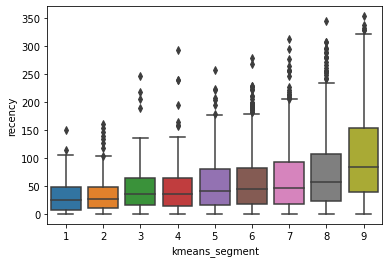

In [556]:
sns.boxplot(data=rfm, x='kmeans_segment', y='recency')

<AxesSubplot:xlabel='kmeans_segment', ylabel='frequency'>

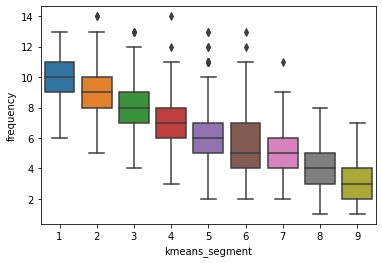

In [557]:
sns.boxplot(data=rfm, x='kmeans_segment', y='frequency')

<AxesSubplot:xlabel='kmeans_segment', ylabel='monetary'>

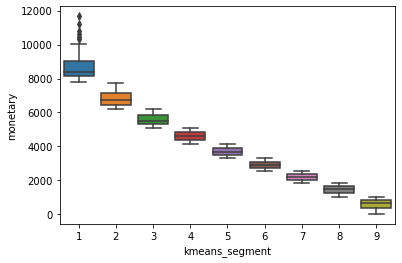

In [558]:
# boxplot to visualise clusters by monetary value
sns.boxplot(data=rfm, x='kmeans_segment', y='monetary')

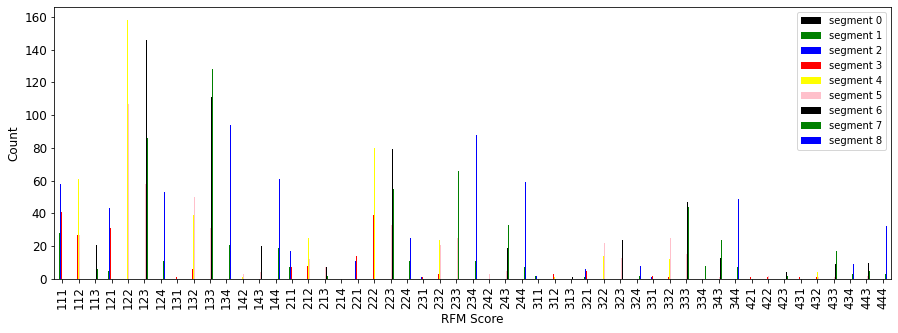

In [559]:
myDict = {}
for i in range(0, len(rfm['kmeans_segment'].unique())):
    clust = rfm[rfm['kmeans_segment'] == i]
    myDict["segment " + str(i)] = clust['rfm_j_score'].value_counts()
df = pd.DataFrame.from_dict(myDict)
colors = ['black', 'green', 'blue', 'red', 'yellow', 'pink']
ax = df.plot(kind='bar', figsize=(15, 5), legend=True, fontsize=12, color=colors)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

In [560]:
rfm.kmeans_cluster.value_counts()

1    613
4    590
0    543
8    514
7    419
3    376
6    251
2    139
5     47
Name: kmeans_cluster, dtype: int64

We can see that K-means clustering has divided customers into clusters. Customers in each cluster have similar buying behaviours, so we can use personalised marketing to offer similar promotions as the results from classical RFM analysis.

K-means clustering provides more comprehensive and diverse segments. However, these segments are harder to interpret.

Ranking of K-means segments from best customers to worst goes from 1 to 7.

We can see that K-means fails to group the data into useful clusters. K-means performs best when the clusters are "round", equally sized, equally dense, and not contaminated by noise/outliers.

# Clustering with HDBSCAN
HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters. 

One advantage of HDBSCAN is its ability to cluster without pulling in the noise, as cluster -1 is the noise.

In [561]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=40,
                            min_samples=40,
                            metric='euclidean')
clusterer.fit(rfm[['recency', 'frequency', 'monetary']])
rfm['HDBSCAN_cluster'] = pd.Series(clusterer.labels_, index=rfm.index)

In [562]:
rfm.head(5)

,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,r_j_score,f_j_score,m_j_score,rfm_j_score,rfm_segment,rfm_j_segment,kmeans_cluster,kmeans_segment,HDBSCAN_cluster
customer_id,,,,,,,,,,,,,,,,
1,7.0,11,3018.09,1,1,2,112,1,1,3,113,2 loyal customers,2 loyal customers,4,6,4
2,128.0,3,2226.26,4,4,3,443,3,4,3,343,7 lost cheap customers,7 lost cheap customers,1,7,-1
3,102.0,7,3290.21,4,2,2,422,2,2,3,223,3 big spenders,2 loyal customers,4,6,-1
4,195.0,2,220.57,4,4,4,444,4,4,4,444,7 lost cheap customers,7 lost cheap customers,3,9,-1
5,16.0,6,2394.94,1,2,3,123,1,2,3,123,2 loyal customers,2 loyal customers,1,7,4


Let's visualise the clusters in 3D:

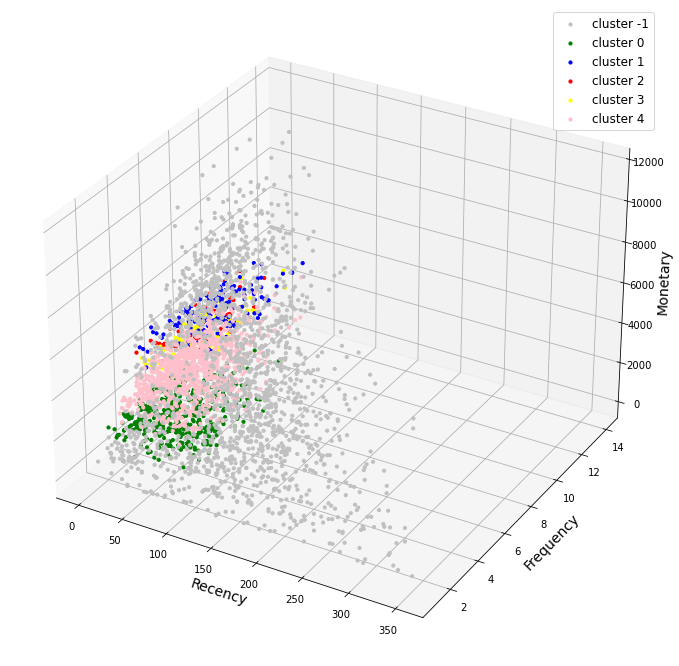

In [563]:
fig = plt.figure(figsize=(18,12))
dx = fig.add_subplot(111, projection='3d')
colors = ['green', 'blue', 'red', 'yellow', 'pink', 'purple', 'silver']
#colors = [ k for k in mcolors.CSS4_COLORS ]
                  
for i in range(-1,len(rfm['HDBSCAN_cluster'].unique())-1):
    dx.scatter(rfm[rfm.HDBSCAN_cluster == i].recency, 
               rfm[rfm.HDBSCAN_cluster == i].frequency, 
               rfm[rfm.HDBSCAN_cluster == i].monetary, 
               c = colors[i], 
               label = 'cluster ' + str(i), 
               s=10, alpha=1.0)
dx.set_xlabel('Recency', fontsize=14)
dx.set_ylabel('Frequency', fontsize=14)
dx.set_zlabel('Monetary', fontsize=14)
dx.legend(fontsize=12)

<AxesSubplot:ylabel='$\\lambda$ value'>

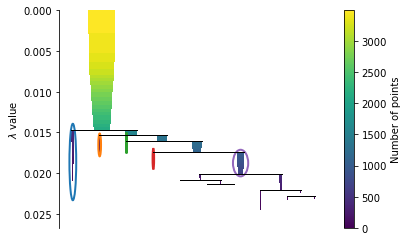

In [564]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [565]:
rfm.HDBSCAN_cluster.value_counts()

-1    1728
 4     992
 0     442
 1     178
 3     100
 2      52
Name: HDBSCAN_cluster, dtype: int64

In [566]:
myDict = {}
for i in range(0, len(rfm['HDBSCAN_cluster'].unique())-1):
    clust = rfm[rfm['HDBSCAN_cluster'] == i]
    myDict['HDBSCAN_cluster ' + str(i)] = [int(round(clust['recency'].mean(),0)),
                            int(round(clust['frequency'].mean(),0)),
                            int(round(clust['monetary'].mean(),0)),
                            int(round(clust['recency'].median(),0)),
                            int(round(clust['frequency'].median(),0)),
                            int(round(clust['monetary'].median(),0))]
    
comparison_df3 = pd.DataFrame.from_dict(myDict, orient='index',
                            columns=['mean_recency','mean_frequency', 'mean_monetary',
                                    'median_recency','median_frequency', 'median_monetary'])
comparison_df3

,mean_recency,mean_frequency,mean_monetary,median_recency,median_frequency,median_monetary
HDBSCAN_cluster 0,43,4,1560,42,4,1607
HDBSCAN_cluster 1,33,7,4711,32,7,4707
HDBSCAN_cluster 2,25,7,4273,28,6,4273
HDBSCAN_cluster 3,31,7,3941,25,7,3929
HDBSCAN_cluster 4,36,6,2795,32,6,2740


Let's see how the clusters compare with the RFM scores:

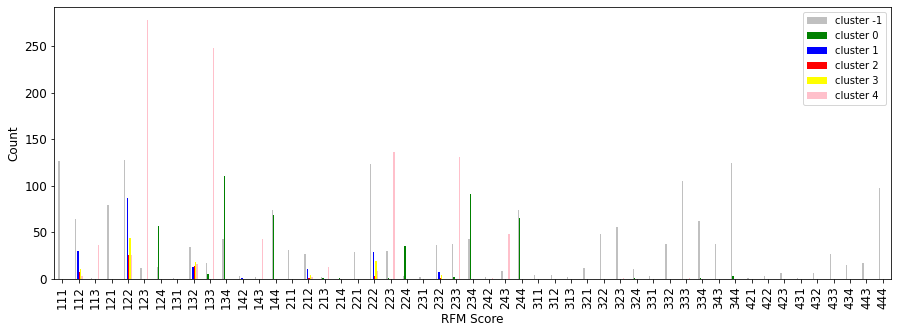

In [567]:
myDict = {}
for i in range(-1, len(rfm['HDBSCAN_cluster'].unique())-1):
    clust = rfm[rfm['HDBSCAN_cluster'] == i]
    myDict["cluster " + str(i)] = clust['rfm_j_score'].value_counts()
df = pd.DataFrame.from_dict(myDict)
colors = ['silver', 'green', 'blue', 'red', 'yellow', 'pink']
ax = df.plot(kind='bar', figsize=(15, 5), legend=True, fontsize=12, color=colors)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

<AxesSubplot:xlabel='HDBSCAN_cluster', ylabel='recency'>

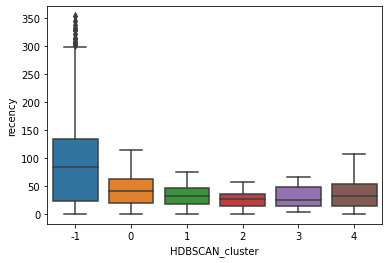

In [568]:
sns.boxplot(data=rfm, x='HDBSCAN_cluster', y='recency')

<AxesSubplot:xlabel='HDBSCAN_cluster', ylabel='frequency'>

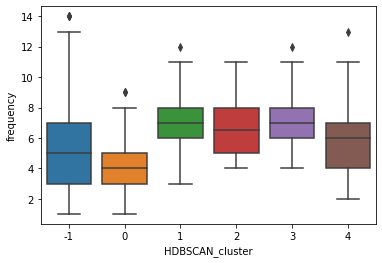

In [569]:
sns.boxplot(data=rfm, x='HDBSCAN_cluster', y='frequency')

<AxesSubplot:xlabel='HDBSCAN_cluster', ylabel='monetary'>

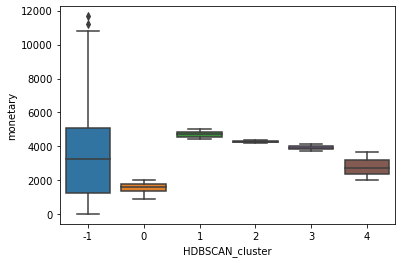

In [570]:
sns.boxplot(data=rfm, x='HDBSCAN_cluster', y='monetary')

We can see that the HDBSCAN clustering has segmented the customers into the following groups:
- Clusters 1 - best customers (high spenders)
- Cluster 2 - best customers (most recent)
- Cluster 3 - good customers (recent)
- Cluster 4 - almost lost
- Cluster 0 - lost customers

HDBSCAN was chosen as the preferred clustering technique as it can cluster without factoring in noise.

In [571]:
hdbscan_segmentation_map = {
    -1: '6 noise',
    0: '5 lost customers',
    1: '2 best - high spend',
    2: '1 best - most recent',
    3: '3 good - recent',
    4: '4 almost lost'
}

In [572]:
rfm['HDBSCAN_segment'] = rfm['HDBSCAN_cluster']
rfm['HDBSCAN_segment'] = rfm['HDBSCAN_segment'].replace(hdbscan_segmentation_map)

## Export to csv for Power BI

In [459]:
customers.to_csv('customers.csv')
addresses.to_csv('addresses.csv')
transactions.to_csv('transactions.csv')

In [574]:
rfm.to_csv('rfm_table.csv')